Runs Greedy optimization of objective using GB1 dataset.

In [1]:
import torch
from torch import distributions as dist

import itertools
import pickle
import operator
import importlib

import random
import math
import numpy as np
import pandas as pd
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('white')
sns.set_context('paper')
# Plot adjustments:
plt.rcParams.update({'ytick.labelsize': 25})
plt.rcParams.update({'xtick.labelsize': 25})
plt.rcParams.update({'axes.labelsize': 35})
plt.rcParams.update({'legend.fontsize': 30})
plt.rcParams.update({'axes.titlesize': 16})

from gptorch import kernels, models

import helpers, opt, bases

In [2]:
with open('../inputs/GB1.pkl', 'rb') as f:
    t = pickle.load(f)

X = t[0] # one-hot encoding of X
T = t[1] # tokenized encoding of X
A = t[2]
y = t[3].values

In [3]:
wt = "VDGV"  # wt as string
aas = 'ARNDCQEGHILKMFPSTWYV'

In [4]:
seq_to_x = {}
for i, x in enumerate(X):
    seq = helpers.decode_X(x)
    seq_to_x[seq] = i

In [26]:
singles = [wt[:i] + aas[j] + wt[i+1:] for i in range(4) for j in range(20)]
train_seqs = singles
wt_inds = [seq_to_x[wt]]
train_inds = wt_inds + [seq_to_x[seq] for seq in train_seqs]
np.random.seed(120120)
train_inds = wt_inds + list(np.random.choice(len(X), 100, replace=True))

X_train = X[train_inds]
y_train = y[train_inds]
X_test = X
y_true = y

A_train = A[train_inds]
A_test = A

In [27]:
ground = [(aa, i) for aa in aas for i in range(4)]

In [37]:
helpers = importlib.reload(helpers)
opt = importlib.reload(opt)
bases = importlib.reload(bases)


n_start = 35
max_its = 30
rounds = 4
L = 4
n = 100

observed_inds = [train_inds]
X_sampled = [A[train_inds]]
y_sampled = [y[train_inds]]



libraries = []
histories = []

for rou in range(rounds):
    print('Round %d' %rou)
    inds = sorted(set(itertools.chain(*observed_inds)))
    print(len(inds))
    dic, _ = helpers.get_predictions(A[inds], y[inds], A_test, one_hots=X_test, its=2000, lr=1e-2)
    seen_seqs = [helpers.decode_X(X[i]) for i in inds]
    for s in seen_seqs:
        dic[s] = 0.0
    print()
    seed = helpers.get_seed(dic)
    chosen, obj = bases.greedy(bases.objective, seed, obj_args=(L, dic, n))
    libraries.append(chosen)
    histories.append(obj)
    seqs = helpers.seqs_from_set(chosen, L)
    inds = np.random.choice(len(seqs), n, replace=True)
    sampled_seqs = [seqs[i] for i in inds]
    inds = [seq_to_x[s] for s in sampled_seqs]
    X_sampled.append(A[inds])
    y_sampled.append(y[inds])
    observed_inds.append(inds)
    
    

Round 0
101
Iteration 2000 of 2000	NLML: 49.0147	sn: 0.199854	
Round 1
200
Iteration 2000 of 2000	NLML: 79.5225	sn: 0.176414	
Round 2
268
Iteration 2000 of 2000	NLML: 64.5932	sn: 0.085434	
Round 3
343
Iteration 2000 of 2000	NLML: 3.8045	sn: 0.041321		


In [38]:
libraries

[[('W', 0),
  ('N', 1),
  ('Q', 2),
  ('W', 3),
  ('A', 0),
  ('R', 1),
  ('R', 2),
  ('A', 3),
  ('R', 0),
  ('D', 1),
  ('D', 2),
  ('C', 3),
  ('N', 0),
  ('C', 1),
  ('Q', 3),
  ('F', 2),
  ('C', 0),
  ('E', 3),
  ('G', 2),
  ('M', 1),
  ('E', 0),
  ('L', 3),
  ('I', 0),
  ('G', 3),
  ('L', 0),
  ('H', 3),
  ('V', 1),
  ('P', 0),
  ('P', 3),
  ('F', 0),
  ('I', 3),
  ('V', 2),
  ('K', 0),
  ('G', 0),
  ('F', 3),
  ('D', 0),
  ('G', 1),
  ('Y', 3),
  ('V', 0),
  ('S', 3),
  ('R', 3)],
 [('R', 0),
  ('Y', 1),
  ('Q', 2),
  ('I', 3),
  ('A', 3),
  ('V', 1),
  ('W', 1),
  ('R', 2),
  ('V', 3),
  ('H', 0),
  ('I', 1),
  ('M', 3),
  ('W', 3),
  ('F', 1),
  ('L', 3),
  ('L', 1)],
 [('V', 0),
  ('D', 1),
  ('R', 2),
  ('Q', 3),
  ('I', 0),
  ('A', 3),
  ('E', 1),
  ('K', 3),
  ('K', 1),
  ('L', 0),
  ('R', 3),
  ('N', 1),
  ('Q', 1),
  ('R', 1),
  ('N', 3),
  ('T', 1),
  ('H', 1),
  ('S', 1)],
 [('I', 0),
  ('D', 1),
  ('R', 2),
  ('A', 3),
  ('N', 1),
  ('V', 0),
  ('K', 1),
  ('L', 0),
 

In [39]:
histories

[tensor(-0.1409), tensor(-4.9379), tensor(-7.6119), tensor(-7.6029)]

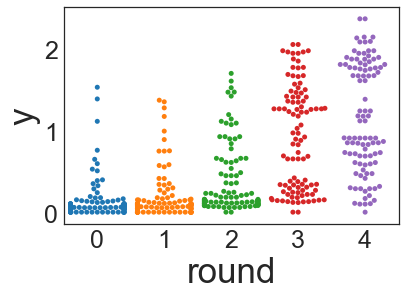

In [40]:
df = pd.DataFrame(np.exp(np.concatenate(y_sampled)), columns=['y'])
df['round'] = [0] * (n + 1) + [1] * n + [2] * n + [3] * n + [4] * n
_ = sns.swarmplot(data=df, x='round', y='y')

In [41]:
[max(yy) for yy in y_sampled]

[0.42967125497365644,
 0.32158124926803683,
 0.5336155150240063,
 0.7209161521736925,
 0.8622705203669584]

In [33]:
[opt.get_N(lib, L) for lib in libraries]

[8232, 120, 126, 130]

In [42]:
df.to_csv('../outputs/greedy_gb1.txt', index=False)